In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os, PIL, pathlib
import numpy as np
import pandas as pd
import warnings
from tensorflow import keras

warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

In [3]:
data_dir = '26-data'
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*')))
print('图片总数:', image_count)

图片总数: 13403


In [5]:
batch_size = 16
img_height = 224
img_width = 224

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=12,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=12,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 13403 files belonging to 2 classes.
Using 10723 files for training.
Found 13403 files belonging to 2 classes.
Using 2680 files for validation.


In [9]:
class_names = train_ds.class_names

print(class_names)

['0', '1']


In [11]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(16, 224, 224, 3)
(16,)


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

def train_preprocessing(image, label):
    return (image/255.0, label)

train_ds = (
    train_ds.cache()
    .shuffle(1000)
    .map(train_preprocessing)
    # .batch(batch_size)
    .prefetch(buffer_size=AUTOTUNE)
)

val_ds = (
    val_ds.cache()
    .shuffle(1000)
    .map(train_preprocessing)
    # .batch(batch_size)
    .prefetch(buffer_size=AUTOTUNE)
)

In [ ]:
plt.figure(figsize=(10, 8))
plt.suptitle('数据展示')

class_names = ['乳腺癌细胞', '正常细胞']

for images, labels in train_ds.take(1):
    for i in range(15):
        plt.subplot(4, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(class_names[labels[i]-1])

plt.show()

In [39]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation

base_model = keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet', # 使用在ImageNet上预训练的权重
                                                         include_top=False,  # 不包含顶部的全连接层/分类器部分 只保留卷积基
                                                         input_shape=(img_width, img_height, 3),
                                                         pooling='max')

for layer in base_model.layers:
    layer.trainable = True # 通常设置为False 设置为True可进行微调

# 构建自定义顶层
X = base_model.output

X = Dropout(0.5)(X)

output = Dense(len(class_names), activation='softmax')(X)
model = Model(inputs=base_model.input, outputs=output)

In [41]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [43]:
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

NO_EPOCHS = 50
PATIENCE = 10
VERBOSE = 1

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.99 ** (x+NO_EPOCHS))

earlystopper = EarlyStopping(monitor='val_acc', patience=PATIENCE, verbose=VERBOSE, mode='max')

checkpointer = ModelCheckpoint('best_27_model.weights.h5',
                               monitor='val_accuracy',
                               save_best_only=True,
                               save_weights_only=True)

In [45]:
train_model = model.fit(train_ds,
                        epochs=NO_EPOCHS,
                        verbose=1,
                        validation_data=val_ds,
                        callbacks=[earlystopper, checkpointer, annealer])

Epoch 1/50
671/671 ━━━━━━━━━━━━━━━━━━━━ 482s 705ms/step - accuracy: 0.7813 - loss: 0.9288 - val_accuracy: 0.5000 - val_loss: 2.9424 - learning_rate: 6.0501e-04
Epoch 2/50
671/671 ━━━━━━━━━━━━━━━━━━━━ 472s 704ms/step - accuracy: 0.8401 - loss: 0.4516 - val_accuracy: 0.5011 - val_loss: 2.7271 - learning_rate: 5.9896e-04
Epoch 3/50
671/671 ━━━━━━━━━━━━━━━━━━━━ 481s 717ms/step - accuracy: 0.8190 - loss: 0.4999 - val_accuracy: 0.4996 - val_loss: 1.5691 - learning_rate: 5.9297e-04
Epoch 4/50
671/671 ━━━━━━━━━━━━━━━━━━━━ 490s 730ms/step - accuracy: 0.8341 - loss: 0.4480 - val_accuracy: 0.4996 - val_loss: 3.2436 - learning_rate: 5.8704e-04
Epoch 5/50
671/671 ━━━━━━━━━━━━━━━━━━━━ 487s 726ms/step - accuracy: 0.8535 - loss: 0.3829 - val_accuracy: 0.6377 - val_loss: 1.2045 - learning_rate: 5.8117e-04
Epoch 6/50
671/671 ━━━━━━━━━━━━━━━━━━━━ 487s 726ms/step - accuracy: 0.8389 - loss: 0.4302 - val_accuracy: 0.5078 - val_loss: 0.9969 - learning_rate: 5.7535e-04
Epoch 7/50
671/671 ━━━━━━━━━━━━━━━━━━━━ 

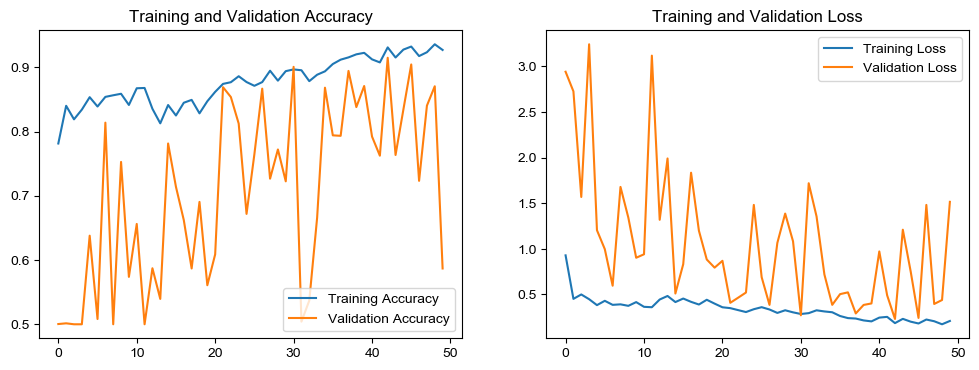

In [47]:
acc = train_model.history['accuracy']
val_acc = train_model.history['val_accuracy']

loss = train_model.history['loss']
val_loss = train_model.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

def plot_cm(labels, predictions):
    conf_numpy = confusion_matrix(labels, predictions)
    conf_df = pd.DataFrame(conf_numpy, index=class_names, columns=class_names)
    plt.figure(figsize=(8, 7))
    sns.heatmap(conf_df, annot=True, fmt='d', cmap='BuPu')
    plt.title('混淆矩阵', fontsize=15)
    plt.ylabel('真实值', fontsize=14)
    plt.xlabel('预测值', fontsize=14)

In [ ]:
val_pre = []
val_label = []

for images, labels in val_ds:
    for image, label in zip(images, labels):
        img_array = tf.expand_dims(image, 0)
        prediction = model.predict(img_array)
        val_pre.append(class_names[np.argmax(prediction)])
        val_label.append(class_names[label])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

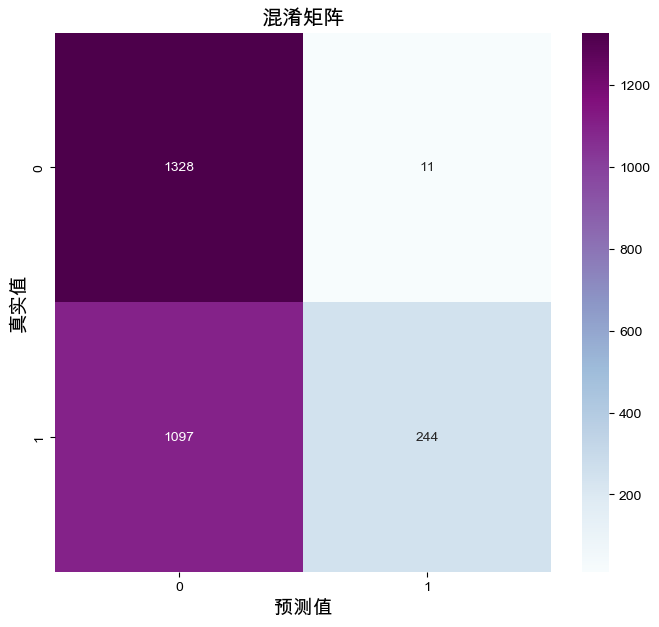

In [56]:
plot_cm(val_label, val_pre)

In [58]:
from sklearn import metrics

def test_accuracy_report(model):
    print(metrics.classification_report(val_label, val_pre, target_names=class_names))
    score = model.evaluate(val_ds, verbose=0)
    print('Loss function: %s, accuracy:' % score[0], score[1])

test_accuracy_report(model)

              precision    recall  f1-score   support

           0       0.55      0.99      0.71      1339
           1       0.96      0.18      0.31      1341

    accuracy                           0.59      2680
   macro avg       0.75      0.59      0.51      2680
weighted avg       0.75      0.59      0.51      2680

Loss function: 1.515618920326233, accuracy: 0.5865671634674072
